# QAQC Plot for LARGEEE

Note: Change `table_name` in "Load Data" Section before running notebook (they are marked with TODO)

## Import modules

In [1]:
# change to specific directory of jupyter notebook
# make sure to install BSQ and pandas at local directory
# launch jupyter notebook from VS Code command line
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import boto3
from itertools import cycle, product
import re

from buildstock_query import BuildStockQuery

## Constants & Funcs

In [59]:
NG_HEAT_CONTENT = 1034.0 # BTU/ft3 - https://www.eia.gov/dnav/ng/ng_cons_heat_a_EPG0_VGTH_btucf_a.htm
MBTU_TO_THERM = 10
KBTU_TO_THERM = 1e-2
MBTU_TO_KWH = 293.07107
KBTU_TO_KWH = 0.29307107
KBTU_TO_MBTU = 1e-3
MBTU_TO_TBTU = 1e-6
KWH_TO_MWH = 1e-3
KWH_TO_GWH = 1e-6

output_dir = Path(".").resolve() / "data" / "output"
output_dir.mkdir(parents=True, exist_ok=True)


### Set up S3 parameters
If there are new runs on S3, change s3_prefix in download_s3_files_for_topic() below (they are marked with TODO)


In [15]:
### [1] S3 download func
def download_s3_directory(s3_bucket, s3_prefix, destination):
    destination = Path(destination)

    s3 = boto3.client("s3")
    for item in s3.list_objects(Bucket=s3_bucket, Prefix=s3_prefix)["Contents"]:
        s3_path = item["Key"]
        if s3_path.endswith(".parquet"):
            local_path = destination / Path(s3_path).name
            if not local_path.exists():
                local_path.parent.mkdir(parents=True, exist_ok=True)
                s3.download_file(s3_bucket, s3_path, local_path.as_posix())

    print(f"S3 directory: s3://{s3_bucket}/{s3_prefix}/ downloaded to: {destination}")

def download_s3_files(s3_prefix, s3_bucket="largeee", destination="auto", check_files_against_s3=False):
    """ Download summary files (baseline and upgrade) for LA100 topic run 
    Args :
        s3_prefix : str
            s3 subpath to directory from bucket name
        destination : str | Path
            local directory for downloaded files (files are downloaded as "results_up00.parquet", etc)
        check_files_against_s3 : bool
            if True, each item within s3://<s3_bucket>/<s3_prefix> are checked and downloaded accordingly
            if False, only download s3 files if destination does not exist or is empty
    """
    if destination == "auto":
        destination = get_localdir_for_run(s3_prefix)
    else:
        destination = Path(destination)
    
    if not check_files_against_s3:
        # do simple check
        if destination.exists() and len([x for x in destination.rglob("*.parquet")])>0:
            print(f"{destination} files exist, no downloading")
            return

    s3_prefix = s3_prefix.removesuffix("/")
    try:
        download_s3_directory(s3_bucket, s3_prefix+"/baseline", destination)
    except KeyError:
        print(f"No baseline for {s3_prefix}")
        pass
    try:
        download_s3_directory(s3_bucket, s3_prefix+"/upgrades", destination)
    except KeyError:
        print(f"No upgrades for {s3_prefix}")
        pass
    print("Downloading completed")

def get_localdir_for_run(s3_prefix):
    """ where resstock results should download to 
    Take folder name of s3_prefix
    """
    table_name = Path(s3_prefix).stem
    data_dir = Path(".").resolve() / "data" / table_name
    print(f"Data directory: {data_dir}")
    return data_dir

## for Timeseries query
def initialize_buidstock_query(table_name):
    bsq = BuildStockQuery(db_name='largeee',
                            table_name=table_name,
                            workgroup='factsheets',
                            buildstock_type='resstock')
    return bsq

In [53]:
enduse_category_dict = {
        "battery": "pv_gen_storage",
        "ceiling_fan": "ceiling_fan",
        "clothes_dryer": "clothes_dryer",
        "clothes_washer": "clothes_washer",
        "cooling": "cooling",
        "cooling_fans_pumps": "hvac_fan_pump",
        "dehumidifier": "hvac_fan_pump",
        "dishwasher": "dishwasher",
        "electric_vehicle_charging": "ev",
        "fireplace": "fireplace",
        "freezer": "freezer",
        "generator": "pv_gen_storage",
        "grill": "cooking",
        "heating": "heating",
        "heating_fans_pumps": "hvac_fan_pump",
        "heating_heat_pump_backup": "heating",
        "hot_tub_heater": "pool_hot_tub",
        "hot_tub_pump": "pool_hot_tub",
        "hot_water": "hot_water",
        "hot_water_recirc_pump": "hot_water",
        "hot_water_solar_thermal_pump": "hot_water",
        "lighting": "exterior_lighting",
        "lighting_exterior": "exterior_lighting",
        "lighting_garage": "exterior_lighting",
        "lighting_interior": "interior_lighting",
        "mech_vent": "vent_fans",
        "mech_vent_precooling": "vent_fans",
        "mech_vent_preheating": "vent_fans",
        "pv": "pv_gen_storage",
        "plug_loads": "plug_loads",
        "pool_heater": "pool_hot_tub",
        "pool_pump": "pool_hot_tub",
        "range_oven": "cooking_range",
        "refrigerator": "refrigerator",
        "television": "plug_loads",
        "well_pump": "well_pump",
        "whole_house_fan": "hvac_fan_pump",
    }

len(enduse_category_dict)

37

In [19]:
### [2] Load func
def load_baseline_and_upgrades(data_dir, baseline_data_dir=None, valid_only=True):
    """ 
    Load files by combining baseline and upgrades
    
    Returns:
        dfb : pd.DataFrame 
            baseline dataframe
        DFU : dict
            dictionary of upgrade dataframes : {upgrade_name: dataframe}
    """
    if baseline_data_dir is None:
        print(f"Using data_dir for daseline_data_dir: {data_dir}")
        baseline_data_dir = data_dir
    dfb = pd.read_parquet(baseline_data_dir / "results_up00.parquet")
    dfb = dfb.sort_values(by=["building_id"]).reset_index(drop=True)
    print(f'Baseline: {dfb.groupby(["completed_status"])["building_id"].count()}')
    if valid_only:
        bcond = dfb["completed_status"]=="Success"
        dfb = dfb.loc[bcond]
    dfb = dfb.set_index("building_id").sort_index()

    upgrade_files = sorted([x for x in data_dir.rglob("*.parquet") if x.name != "results_up00.parquet"])
    DFU =dict()
    for file in upgrade_files:
        dfu = pd.read_parquet(file)
        dfu = dfu.sort_values(by=["building_id"]).reset_index(drop=True)
        upg_name = dfu["apply_upgrade.upgrade_name"].unique()[0]

        print(f'Upgrade {upg_name}: {dfu.groupby(["completed_status"])["building_id"].count()}')
        if valid_only:
            cond = bcond & (dfu["completed_status"]=="Success") & (dfu["apply_upgrade.applicable"]==True)
            dfu = dfu.loc[cond]
        dfu = dfu.set_index("building_id").sort_index()
        
        DFU[upg_name] = dfu

    return dfb, DFU

In [48]:
### funcs for mapping rep_income recursively
def process_ami_lookup(geography, data_dir):
    """
    geography option: PUMA, State, Census Division

    """
    if geography == "County and PUMA":
        file = "income_bin_representative_values_by_county_puma_occ_FPL.csv"
    elif geography == "PUMA":
        file = "income_bin_representative_values_by_puma_occ_FPL.csv"
    elif geography == "State":
        file = "income_bin_representative_values_by_state_occ_FPL.csv"
    elif geography == "Census Division":
        file = "income_bin_representative_values_by_cendiv_occ_FPL.csv"
    elif geography == "Census Region":
        file = "income_bin_representative_values_by_cenreg_occ_FPL.csv"
    elif geography == "National":
        file = "income_bin_representative_values_by_occ_FPL.csv"
    else:
        raise ValueError(f"geography={geography} not supported")

    ami_lookup = pd.read_csv(data_dir / file)
    deps = ["Occupants", "Federal Poverty Level", "Income"]
    deps = [geography] + deps if geography != "National" else deps
    income_col = "weighted_median"
    ami_lookup = ami_lookup[
        ~ami_lookup[deps + [income_col]].isna().any(axis=1)
    ].reset_index(drop=True)[deps + [income_col]]

    if geography == "PUMA":
        # map puma to version in EUSS
        puma_file_full_path = data_dir / "spatial_puma_lookup-v2.csv"
        if puma_file_full_path.exists():
            puma_map = pd.read_csv(puma_file_full_path)
        else:
            puma_map = pd.read_parquet(data_dir / "spatial_block_lookup_table-v2.parquet")
            puma_map = puma_map[
                ["puma_tsv", "nhgis_2010_puma_gisjoin"]
            ].drop_duplicates()
            puma_map.to_csv(puma_file_full_path, index=False)

        ami_lookup[geography] = ami_lookup[geography].map(
            puma_map.set_index("puma_tsv")["nhgis_2010_puma_gisjoin"]
        )

    ami_lookup = ami_lookup.rename(columns={income_col: "rep_income"})

    return ami_lookup, deps


def get_median_from_bin(value_bin, lower_multiplier=0.9, upper_multipler=1.1):
    if "<" in value_bin:
        return float(value_bin.strip("<")) * lower_multiplier
    if "+" in value_bin:
        return float(value_bin.strip("+")) * upper_multipler

    return np.mean([float(x) for x in value_bin.split("-")])


def assign_representative_income(df, data_dir):
    non_geo_cols = ["build_existing_model.occupants", "build_existing_model.federal_poverty_level", "build_existing_model.income"]
    geographies = [
        "County and PUMA",
        "PUMA",
        "State",
        "Census Division",
        "Census Region",
        ]
    geo_cols = ["build_existing_model." + geo.lower().replace(" ", "_") for geo in geographies]
    df_section = df[geo_cols+non_geo_cols].copy()
    geographies += ["National"]

    # map rep income by increasingly large geographic resolution
    for idx in range(len(geographies)):
        geography = geographies[idx]
        ami_lookup, deps = process_ami_lookup(geography, data_dir)
        if idx == len(geographies)-1:
            keys = non_geo_cols
        else:
            keys = [geo_cols[idx]]+non_geo_cols

        if idx == 0:
            # map value by County and PUMA
            df_section = df_section.join(
                ami_lookup.set_index(deps),
                on=keys,
            )
        else:
            # map remaining value
            df_section.loc[df_section["rep_income"].isna(), "rep_income"] = (
                df_section[keys]
                .astype(str)
                .agg("-".join, axis=1)
                .map(
                    ami_lookup.assign(
                        key=ami_lookup[deps].astype(str).agg("-".join, axis=1)
                    ).set_index("key")["rep_income"]
                )
            )
            if len(df_section[df_section["rep_income"].isna()]) == 0:
                print(f"Highest resolution used for mapping representative income: {geography}")
                break

    if len(df_section[df_section["rep_income"].isna()]) > 0: 
        df_in_question = df_section.loc[df_section["rep_income"].isna()]
        assert list(df_in_question["build_existing_model.occupants"].unique()) == ["0"], f"rep_income cannot be mapped for the following:\n{df_in_question}"

    df["rep_income"] = df_section["rep_income"]

    return df

In [81]:
### [3] add new cols to df funcs
def calculate_energy_burden(dfi, dfb=None):
    if "rep_income" not in dfi.columns:
        assert dfb is not None, "dfb is required to give 'rep_income' col for calculate_energy_burden"
    else:
        dfb = dfi.copy()

    if "report_utility_bills.bills_total_usd" not in dfi.columns:
        raise ValueError("df does not have bill columns")
    
    if dfi.index.name == "building_id":
        if dfb.index.name == "building_id":
            cond = dfi.index
        else:
            raise ValueError("dfb has different index than dfi")
    
    if dfi.index.name is None:
        if dfb.index.name is None:
            cond = dfb["building_id"].isin(dfi["building_id"])
        else:
            raise ValueError("dfb has different index than dfi")
    
    dfi["energy_burden_pct"] = (dfi["report_utility_bills.bills_total_usd"].div(dfb.loc[cond, "rep_income"], axis=0)*100).round(2)

    return dfi

def add_consolidated_columns(df):
    orig_cols = df.columns
    df["lmi"] = df["build_existing_model.area_median_income"].map({
        "0-30%": "0-80%",
        "30-60%": "0-80%",
        "60-80%": "0-80%",
        "80-100%": "80-120%",
        "100-120%": "80-120%",
        "120-150%": "120%+",
        "150%+": "120%+",
        "Not Available": "Not Available",
    })

    df["fpl"] = df["build_existing_model.federal_poverty_level"].map({
        '0-100%': "0-200%", 
        '100-150%': "0-200%", 
        '150-200%': "0-200%",
        '200-300%': "200-400%",  
        '300-400%': "200-400%",  
        '400%+': "400%+",
        "Not Available": "Not Available",
        })

    df["tenure"] = df["build_existing_model.tenure"]

    df["iqr_cohort_energy"] = divide_iqr_cohort_based_on(df, "report_simulation_output.energy_use_total_m_btu")
    df["iqr_cohort_electricity"] = divide_iqr_cohort_based_on(df, "report_simulation_output.fuel_use_electricity_total_m_btu")

    df["iqr_cohort_utility_bill"] = divide_iqr_cohort_based_on(df, "report_utility_bills.bills_total_usd")
    df["iqr_cohort_electric_bill"] = divide_iqr_cohort_based_on(df, "report_utility_bills.bills_electricity_total_usd")

    new_cols = [col for col in df.columns if col not in orig_cols]
    return df, new_cols

def map_representative_income(baseline_df):
    income_lookup_dir = Path(".").resolve() / "data" / "helper_files"
    baseline_df = assign_representative_income(baseline_df, income_lookup_dir)

    return baseline_df

def get_upgrade_saving_dataframe(dfb, DFU, metric, output_type="saving", add_metadata=True):
    """ Calculate saving or delta for metric for each upgrade, concatenate into a single dataframe with baseline metadata
    saving = baseline - upgrade
    delta = upgrade - baseline
    """
    if output_type not in ["saving", "delta"]:
        raise ValueError(f"Unsupported output_type={output_type}, valid options = ['saving', 'delta']")
    
    DF = []
    meta_cols = [col for col in dfb.columns if not col.startswith("report_simulation_output")]
    for dfu in DFU.values():
        delta = (dfu[metric] - dfb.loc[dfu.index, metric])
        if output_type=="saving":
            delta *= -1
    
        if add_metadata:
            df = pd.concat([
                dfb.loc[dfu.index, meta_cols],
                dfu["apply_upgrade.upgrade_name"].rename("upgrade"), 
                delta.rename(metric+f"_{output_type}"),
                ], axis=1).reset_index()
        else:
            df = pd.concat([
                dfu["apply_upgrade.upgrade_name"].rename("upgrade"), 
                delta.rename(metric+f"_{output_type}"),
                ], axis=1).reset_index()
            
        DF.append(df)

    DF = pd.concat(DF, axis=0, ignore_index=True)

    return DF

In [66]:
### [4] Helper/utility funcs
def divide_iqr_cohort_based_on(df, metric):
    p25 = df[metric].quantile(0.25)
    p75 = df[metric].quantile(0.75)
    col = pd.Series("p25-p75", index=df.index)
    col.loc[df[metric]<p25] = "<p25"
    col.loc[df[metric]>p75] = ">p75"

    return col

def extract_left_edge(val):
    # for sorting things like AMI
    if val is None:
        return np.nan
    if not isinstance(val, str):
        return val
    first = val[0]
    if re.search(r"\d", val) or first in ["<", ">"] or first.isdigit():
        vals = [int(x) for x in re.split("\-| |\%|\<|\+|\>|s|th|p", val) if re.match("\d", x)]
        if len(vals) > 0:
            num = vals[0]
            if "<" in val:
                num -= 1
            if ">" in val:
                num += 1
            return num
    return val

def sort_index(df, axis="index", **kwargs):
    """ axis: ['index', 'columns'] """
    if axis in [0, "index"]:
        try:
            df = df.reindex(sorted(df.index, key=extract_left_edge, **kwargs))
        except TypeError:
            df = df.sort_index()
        return df
    if axis in [1, "columns"]:
        col_index_name = df.columns.name
        try:
            cols = sorted(df.columns, key=extract_left_edge, **kwargs)
        except TypeError:
            cols = sorted(df.columns)
        df = df[cols]
        df.columns.name = col_index_name
        return df
    raise ValueError(f"axis={axis} is invalid")

def get_conversion_factor(metric):
    factor = 1
    new_metric = metric
    if "electricity" in metric:
        if "m_btu" in metric:
            factor = MBTU_TO_KWH
            new_metric = metric.replace("m_btu", "kwh")
        elif "k_btu" in metric:
            factor  = KBTU_TO_KWH
            new_metric = metric.replace("k_btu", "kwh")
    elif "natural_gas" in metric:
        if "m_btu" in metric:
            factor = MBTU_TO_THERM
            new_metric = metric.replace("m_btu", "therm")
        elif "k_btu" in metric:
            factor  = KBTU_TO_THERM
            new_metric = metric.replace("k_btu", "therm")
    
    if "." in new_metric:
        new_metric = new_metric.split(".")[-1]
        
    return factor, new_metric

def get_95_confidence_interval(data):
    """ data: pd.Series """
    avg = data.mean()
    delta = 1.96*data.std()/np.sqrt(len(data))
    return avg-delta, avg+delta
### [4] Helper/utility funcs
def divide_iqr_cohort_based_on(df, metric):
    p25 = df[metric].quantile(0.25)
    p75 = df[metric].quantile(0.75)
    col = pd.Series("p25-p75", index=df.index)
    col.loc[df[metric]<p25] = "<p25"
    col.loc[df[metric]>p75] = ">p75"

    return col

def extract_left_edge(val):
    # for sorting things like AMI
    if val is None:
        return np.nan
    if not isinstance(val, str):
        return val
    first = val[0]
    if re.search(r"\d", val) or first in ["<", ">"] or first.isdigit():
        vals = [int(x) for x in re.split("\-| |\%|\<|\+|\>|s|th|p", val) if re.match("\d", x)]
        if len(vals) > 0:
            num = vals[0]
            if "<" in val:
                num -= 1
            if ">" in val:
                num += 1
            return num
    return val

def sort_index(df, axis="index", **kwargs):
    """ axis: ['index', 'columns'] """
    if axis in [0, "index"]:
        try:
            df = df.reindex(sorted(df.index, key=extract_left_edge, **kwargs))
        except TypeError:
            df = df.sort_index()
        return df
    if axis in [1, "columns"]:
        col_index_name = df.columns.name
        try:
            cols = sorted(df.columns, key=extract_left_edge, **kwargs)
        except TypeError:
            cols = sorted(df.columns)
        df = df[cols]
        df.columns.name = col_index_name
        return df
    raise ValueError(f"axis={axis} is invalid")

def get_conversion_factor(metric):
    factor = 1
    new_metric = metric
    if "electricity" in metric:
        if "m_btu" in metric:
            factor = MBTU_TO_KWH
            new_metric = metric.replace("m_btu", "kwh")
        elif "k_btu" in metric:
            factor  = KBTU_TO_KWH
            new_metric = metric.replace("k_btu", "kwh")
    elif "natural_gas" in metric:
        if "m_btu" in metric:
            factor = MBTU_TO_THERM
            new_metric = metric.replace("m_btu", "therm")
        elif "k_btu" in metric:
            factor  = KBTU_TO_THERM
            new_metric = metric.replace("k_btu", "therm")
    
    if "." in new_metric:
        new_metric = new_metric.split(".")[-1]
        
    return factor, new_metric

def get_95_confidence_interval(data):
    """ data: pd.Series """
    avg = data.mean()
    delta = 1.96*data.std()/np.sqrt(len(data))
    return avg-delta, avg+delta


In [76]:
### [5] plot funcs
# [5.1]
def plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95"):
    """ 
    For plotting histogram with hard coded logic for dfb and DFU
    column subplots: unique hc field
    row subplots: baseline + upgrades
    """
    if dashline_bounds not in ["95%CI", "IQR", "p95", None]:
        raise ValueError(f'Unsupported dashline_bounds={dashline_bounds}, valid options: ["95%CI", "IQR", "p95", None]')

    hc_values = sorted(dfb[hc].unique(), key=extract_left_edge)
    ncols = dfb[hc].nunique()
    nrows = len(DFU)+1
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*2, nrows*1.25))

    upgs = list(DFU.keys())
    dfs = list(DFU.values())

    factor, new_metric = get_conversion_factor(metric)
    new_hc = hc
    if "." in hc:
        new_hc = hc.split(".")[-1]

    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = cycle(prop_cycle.by_key()['color'])
    avg_vals, lb_vals, ub_vals = [], [], []
    for i in range(ncols):
        cond = dfb[hc]==hc_values[i]
        ax = axes[0, i]
        data = dfb.loc[cond, metric]*factor
        
        ndata = len(data)
        data = data.replace([np.inf, -np.inf], np.nan).dropna()
        if ndata > len(data):
            print(f"{ndata-len(data)} infinite value(s) found for {hc}=={hc_values[i]}")
            
        ax.hist(data, bins=nbins, color=next(colors))
        
        avg_vals.append(data.mean())
        if dashline_bounds == "IQR":
            lb_vals.append(data.quantile(0.25))
            ub_vals.append(data.quantile(0.75))
        elif dashline_bounds == "p95":
            lb_vals.append(data.quantile(0.05))
            ub_vals.append(data.quantile(0.95))
        elif dashline_bounds == "95%CI":
            lb, ub = get_95_confidence_interval(data)
            lb_vals.append(lb)
            ub_vals.append(ub)

        ax.set_title(hc_values[i])
        if i == ncols-1:
            ax.legend(["baseline"], loc="center left", bbox_to_anchor=(1, 0.5))

        for j in range(1, nrows):
            ax = axes[j, i]
            data = dfs[j-1].loc[cond, metric]*factor
            data = data.replace([np.inf, -np.inf], np.nan).dropna()
            ax.hist(data, bins=nbins, color=next(colors))
            avg_vals.append(data.mean())
            if dashline_bounds == "IQR":
                lb_vals.append(data.quantile(0.25))
                ub_vals.append(data.quantile(0.75))
            elif dashline_bounds == "p95":
                lb_vals.append(data.quantile(0.05))
                ub_vals.append(data.quantile(0.95))
            elif dashline_bounds == "95%CI":
                lb, ub = get_95_confidence_interval(data)
                lb_vals.append(lb)
                ub_vals.append(ub)

            if i == ncols-1:
                ax.legend([upgs[j-1]], loc="center left", bbox_to_anchor=(1, 0.5))
    
    if xmax == "best":
        # set xmax based on smaller of max or upper bound of 1.5*IQR of baseline, and larger of that or P95
        p75 = dfb[metric].quantile(0.75)
        p25 = dfb[metric].quantile(0.25)
        p95 = dfb[metric].quantile(0.95)
        p100 = dfb[metric].max()
        iqr150 = (p75+(p75-p25)*1.5)
        xmax = max(min(iqr150, p100), p95)*factor
        ax.set_xlim(xmax=xmax)

    xmax = ax.get_xlim()[1]
    ymax = ax.get_ylim()[1]

    k = 0
    for i in range(ncols):
        for j in range(nrows):
            avg = avg_vals[k]
            ax = axes[j, i]
            ax.axvline(avg, color="k")
            ax.text(avg+xmax*0.05, ymax*0.7, f"{avg:.1f}")

            if dashline_bounds is not None:
                ax.axvline(lb_vals[k], color="gray", ls="--")
                ax.axvline(ub_vals[k], color="gray", ls="--")

            k += 1

    fig.suptitle(f"{new_metric} by {new_hc}", fontsize=18, y=0.95)
    
    fig.savefig(output_dir / f"histogram_{new_metric}_by_{new_hc}__{dashline_bounds}.pdf", bbox_inches="tight")


# [5.2]
def plot_histogram_saving(df, value_col: str, by_cols: list, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95", **kwargs):
    """ Specifically for histogram of upgrade savings (i.e., without baseline) or histogram for a dataframe's metric
    xlim : "best" | None | tuple
    """
    if title_prefix is None:
        title_prefix = ""
    else:
        title_prefix = f"{title_prefix.title()} "

    if len(by_cols) not in [1,2]:
        raise ValueError(f"Invalid number of by_cols={by_cols}, can only support up to 2")
    
    if dashline_bounds not in ["95%CI", "IQR", "p95", None]:
        raise ValueError(f'Unsupported dashline_bounds={dashline_bounds}, valid options: ["95%CI", "IQR", "p95", None]')
    
    factor, new_value_col = get_conversion_factor(value_col)
    df[value_col] *= factor

    if xlim == "best":
        # set xmax based on smaller of max or upper bound of 1.5*IQR of baseline, and larger of that or P95
        # equivalent for xmin
        p0 = df[value_col].min()
        p5 = df[value_col].quantile(0.05)
        p25 = df[value_col].quantile(0.25)
        p75 = df[value_col].quantile(0.75)
        p95 = df[value_col].quantile(0.95)
        p100 = df[value_col].max()
        xmin = min(max((p25-(p75-p25)*1.5), p0), p5)
        xmax = max(min((p75+(p75-p25)*1.5), p100), p95)
    elif xlim is not None:
        (xmin, xmax) = xlim

    ext = ""
    if non_zero:
        df = df[df[value_col]>0].reset_index()
        ext = " (non-zero)"

    title = f"{title_prefix}{new_value_col}{ext}"
    if len(by_cols)==1:
        nrows = df[by_cols[0]].nunique()
        ncols = 1
    elif len(by_cols)==2:
        ncols = 1
        for i, col in enumerate(by_cols):
            if i == 0:
                nrows = df[col].nunique()
            else:
                ncols *= df[col].nunique()
        
    df = (df.set_index([df.index]+by_cols)[value_col]).unstack(level=by_cols).dropna(how="all")
    cols = sorted(df.columns, key=extract_left_edge)
    axes = df[cols].plot(kind="hist", subplots=True, sharex=True, sharey=True, legend=False, layout=(nrows, ncols), 
                         figsize=(min(ncols*1.5+2, 12), min(nrows+1, 18)), **kwargs)
        
    axes = axes.flat
    if xlim is not None:
        axes[0].set_xlim(xmin=xmin, xmax=xmax)
    xmax = axes[0].get_xlim()[1]
    ymax = axes[0].get_ylim()[1]
    if len(by_cols)==2:
        for i, ax in enumerate(axes):
            data = df[cols[i]]

            ndata = len(data)
            data = data.replace([np.inf, -np.inf], np.nan).dropna()
            if ndata > len(data):
                print(f"{ndata-len(data)} infinite value(s) found for {cols[i]}")

            # draw average line
            avg = data.mean()
            ax.axvline(avg, color="k")
            ax.text(avg+xmax*0.05, ymax*0.7, f"{avg:.1f}")

            # draw dashline for bounds
            if dashline_bounds == "IQR":
                ax.axvline(data.quantile(0.25), color="gray", ls="--")
                ax.axvline(data.quantile(0.75), color="gray", ls="--")
            elif dashline_bounds == "p95":
                ax.axvline(data.quantile(0.05), color="gray", ls="--")
                ax.axvline(data.quantile(0.95), color="gray", ls="--")
            elif dashline_bounds == "95%CI":
                lb, ub = get_95_confidence_interval(data)
                ax.axvline(lb, color="gray", ls="--")
                ax.axvline(ub, color="gray", ls="--")

            row_index = i // ncols
            col_index = i % ncols
            if row_index == 0:
                ax.set_title(cols[i][1:])
            if col_index == ncols-1:
                h, _ = ax.get_legend_handles_labels()
                ax.legend(h, [cols[i][0]], loc='center left', bbox_to_anchor=(1.01, 0.5), frameon=False)
        
            
    fig = axes[0].get_figure()
    fig.suptitle(title, fontsize=18,  y=0.95)
    # fig.tight_layout()
    
    gb_ext = "-".join([x.split(".")[-1] for x in by_cols])
    fig.savefig(output_dir / f"histogram_saving_{new_value_col}_by_{gb_ext}.pdf", bbox_inches="tight")

    # for col in cols:
    #     print(f" -- {new_value_col} for  {col} -- ")
    #     print((df[col]).describe())

# [5.3]
def plot_aggregated_metric(df2, groupby_cols: list, value_col: str, operation="mean", weight_col=None, non_zero=False, unstack_level=0, title_suffix=None, **kwargs):
    """ non_zero: if True, only non-zero values are aggregated
    """

    n_combo = len(df2[groupby_cols].drop_duplicates())

    if non_zero:
        df = df2.loc[df2[value_col]>0]
        ext = " (non-zero)"
    else:
        df = df2.copy()
        ext = ""
    
    if title_suffix is None:
        ext += ""
    else:
        ext += f" {title_suffix}"

    if weight_col is not None:
        df[value_col] *= df[weight_col]

    if operation == "mean":
        df = df.groupby(groupby_cols)[value_col].mean()
        btype = "avg customer"
    elif operation == "sum":
        df = df.groupby(groupby_cols)[value_col].sum()
        btype = "all customer (unweighted)"
        if weight_col is not None:
            btype = "all customer"
    elif operation == "min":
        df = df.groupby(groupby_cols)[value_col].min()
        btype = "smallest consumer"
    elif operation == "max":
        df = df.groupby(groupby_cols)[value_col].max()
        btype = "largest consumer"
    elif operation == "count":
        df = df.groupby(groupby_cols)[value_col].count()
        btype = "count of samples"
    else:
        raise ValueError(f"operation={operation} not supported")

    df = df.unstack(level=unstack_level)
    cols = df.columns
    try:
        cols = sorted(cols, key=extract_left_edge)
    except TypeError:
        cols = sorted(cols)
    cols_name = df.columns.name
    df = sort_index(df[cols])

    f = plt.figure(figsize=(n_combo*0.13+1.5, 4))
    df.plot(kind="bar", title=f"{value_col} - \n{btype}{ext}",  ax=f.gca(), **kwargs)
    plt.legend(loc='center left', title=cols_name, bbox_to_anchor=(1.0, 0.5))

    gb_ext = "-".join([x.split(".")[-1] for x in groupby_cols])
    f.savefig(output_dir / f"bar_{operation}_{metric}_by_{gb_ext}.pdf", bbox_inches="tight")


# [5.4]
def plot_scatter(dfs, xmetric, ymetric,  plot_row_by: str, plot_column_by: str, groupby_cols: list):
    xlabel = xmetric.split(".")[-1] if "." in xmetric else xmetric
    ylabel = ymetric.split(".")[-1] if "." in ymetric else ymetric

    groupby_vals = [sorted(dfs[col].unique(), key=extract_left_edge) for col in groupby_cols]
    groupby_combos = [vals for vals in product(*groupby_vals)]
    nrows, ncols = dfs[plot_row_by].nunique(), dfs[plot_column_by].nunique()

    prop_cycle = plt.rcParams['axes.prop_cycle']

    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(ncols*3+2, nrows*3))
    for i, upg in enumerate(dfs[plot_row_by].unique()):
        for j, dac in enumerate(dfs[plot_column_by].unique()):
            ax = axes[i, j]
            colors = cycle(prop_cycle.by_key()['color'])
            for vals in groupby_combos:
                dfi = dfs.loc[(dfs[plot_row_by]==upg) & (dfs[plot_column_by]==dac)]
                for k in range(len(groupby_cols)):
                    dfi = dfi.loc[dfi[groupby_cols[k]]==vals[k]]
                label = vals[0] if len(vals)==1 else vals
                ax.scatter(x=dfi[xmetric], y=dfi[ymetric], c=next(colors), alpha=0.25, label=label)
            ax.axhline(0, color="k", ls="--")
            ax.axvline(0, color="k", ls="--")
            if i == nrows-1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if j == ncols-1:
                ax.legend(title=upg, loc="center left", bbox_to_anchor=(1, 0.5))
            ax.set_title(dac)

    gb_ext = "-".join([x.split(".")[-1] for x in groupby_cols])
    fig.savefig(output_dir / f"scatter_saving_{ylabel}_vs_{xlabel}_by_{gb_ext}.pdf", bbox_inches="tight")


In [57]:
### Stacked end use plots
# [1] - normalized
def plot_normalized_stacked_end_uses(dfb, fuel="all fuels"):
    """ Single column stacked bar plot, stacking by the end use of a given fuel """
    fuels = [fuel]
    if fuel == "all fuels":
        fuels = ["electricity", "natural_gas", "propane", "fuel_oil", "wood_cord", "wood_pellets", "coal"]
    enduse_cols, mapped_cols = [], []
    for fu in fuels:
        eu_cols = [col for col in dfb.columns if f"end_use_{fu}" in col]
        enduse_cols += eu_cols
        mapped_cols += [enduse_category_dict[
            col.removeprefix(f"report_simulation_output.end_use_{fu}_").removesuffix("_m_btu")
            ] for col in eu_cols]

    df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()

    cols = sorted(set(mapped_cols))
    data = df[cols].sum(axis=0)
    data = (data/data.sum()).rename(fuel) # normalize

    ax = data.to_frame().stack().unstack(level=0).plot(kind="bar", stacked=True)
    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in data.to_dict().items()]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")

# [2] - normalized
def plot_normalized_stacked_end_uses_by_fuel(dfb):
    """ Multiple column stacked bar plot, stacking by end use, column by fuel """
    DF= []
    fuels = ["coal", "electricity", "fuel_oil", "natural_gas", "propane", "wood_cord", "wood_pellets"]
    for fuel in fuels:
        enduse_cols = [col for col in dfb.columns if f"end_use_{fuel}" in col]
        mapped_cols = [enduse_category_dict[
            col.removeprefix(f"report_simulation_output.end_use_{fuel}_").removesuffix("_m_btu")
            ] for col in enduse_cols]

        df = dfb[enduse_cols].rename(columns=dict(zip(enduse_cols, mapped_cols))).groupby(level=0, axis=1).sum()
        
        cols = sorted(set(mapped_cols))
        data = df[cols].sum(axis=0)
        data = data.rename(fuel)
        DF.append(data)

    DF = pd.concat(DF, axis=1).sort_index(axis=0)
    DF["total"] = DF[DF.columns].fillna(0).sum(axis=1)
    DF /= DF.sum(axis=0) # normalize

    # plot
    ax = DF.transpose().dropna(how="all", axis=0).plot(kind="bar", stacked=True)

    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in DF["total"].to_dict().items()]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses (total fuel saturation)")


# [3] - normalized
def plot_normalized_stacked_fuel_uses(dfb, n_represented="auto"):
    """ Single column stacked bar plot, stacking by fuel use """
    fuels = ["electricity", "natural_gas", "propane", "fuel_oil", "wood_cord", "wood_pellets", "coal"]

    fuel_cols = sorted([f'report_simulation_output.fuel_use_{fuel}_total_m_btu' for fuel in fuels])

    n_customers = dfb["build_existing_model.sample_weight"].sum()
    data = (dfb[fuel_cols].mul(dfb["build_existing_model.sample_weight"], axis=0)).sum(axis=0)

    if n_represented != "auto":
        data *= n_represented / n_customers
        n_customers = n_represented

    data = data.rename(lambda x: x.removeprefix("report_simulation_output.fuel_use_").removesuffix("_total_m_btu"), axis=0).rename("Fuel Use")

    # to Trillion Btu
    data *= MBTU_TO_TBTU
    data_frac = data/data.sum() # normalize

    ax = data.to_frame().stack().unstack(level=0).plot(kind="bar", stacked=True)
    h, l = ax.get_legend_handles_labels()
    labels = [f"{k} ({v*100:.01f}%)" for k, v in data_frac.to_dict().items()]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5), title="End uses: ")
    ax.set_ylabel("trillion Btu")
    ax.set_title(f"Total fuel: {data.sum():.0f} trillion btu from {round(n_customers, 0):.0f} customers")
    
# [4] - total stock monthly stacked end use plot
def plot_monthly_total_stacked_end_uses(df_monthly, fuel, n_represented="auto"):
    """ Multiple column stacked bar plot, stacking by end use, column by month, down-selected to fuel """
    end_uses = sorted([col for col in df_monthly.columns if fuel in col])
    data = df_monthly.set_index("month")[end_uses]

    if n_represented == "auto":
        n = df_monthly["n_represented"].apply(round).unique()
        assert len(n)==1, n
        n_represented = n[0]
    else:
        data = data.div(df_monthly.set_index("month")["n_represented"], axis=0) * n_represented

    ax = data.plot(kind="bar", stacked=True)
    h, l = ax.get_legend_handles_labels()
    labels = [eu.split("__")[1] for eu in l]
    unit = end_uses[0].split("__")[-1]
    ax.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_ylabel(unit)
    ax.set_title(f"Total Stock {fuel.title()} (n={n_represented})")

# [5] - total stock or per unit diurnal stacked end use plot
def plot_seasonal_diurnal_end_uses(df_ts, fuel, stock_total=False, n_represented="auto"):
    """ Subplots of multiple column stacked bar plot, stacking by end use, column by hour, 
    subplot by season and week day type, down-selected to fuel
    """
    end_uses = sorted([col for col in df_ts.columns if fuel in col])
    unit = end_uses[0].split("__")[-1]

    fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)
    for j, season in enumerate(["summer", "winter", "shoulder"]):
        for i, day_type in enumerate(["weekday", "weekend"]):
            cond = df_ts["season"]==season
            cond &= df_ts["day_type"]==day_type
            data = df_ts.loc[cond].groupby(["hour"])

            # auto-stock total
            data_plot= data[end_uses].sum().div(data["n_hours"].sum(), axis=0)
            n_customers = data["n_represented"].mean().apply(round).unique()
            assert len(n_customers)==1, n_customers
            n_customers = n_customers[0]

            if stock_total and n_represented != "auto":
                # renormalized to input n_represented
                data_plot = data_plot.div(data["n_represented"].mean(), axis=0)*n_represented
                n_customers = n_represented
            elif not stock_total:
                # per dwelling unit
                data_plot = data_plot.div(data["n_represented"].mean(), axis=0)

            ax = axes[j, i]
            data_plot.plot(ax = ax, kind="area", stacked=True, legend=False, figsize=(8,8))
            ax.margins(x=0)
            ax.set_ylabel(unit)
            ax.set_title(f"{season} - {day_type}")


    h, l = ax.get_legend_handles_labels()
    h, l = ax.get_legend_handles_labels()
    labels = [eu.split("__")[1] for eu in l]

    fig.legend(h[::-1], labels[::-1], loc="center left", bbox_to_anchor=(1, 0.5))
    if not stock_total:
        title = f"Per Dwelling Unit {fuel.title()}"
    else:
        title = f"Total Stock {fuel.title()} (n={n_customers})"

    fig.suptitle(title)
    fig.tight_layout()

## Download data

In [13]:
### run CLI to see what's available
!aws s3 ls largeee/test_runs/

                           PRE baseline_20230525/
                           PRE cateory_2_20230525/
                           PRE cateory_3_20230525/
                           PRE cateory_4_20230525/
2023-05-20 19:37:05          0 


In [18]:
table_name = "cateory_4_20230525" # <---- TODO
s3_prefix = f"test_runs/{table_name}/" 

data_dir = get_localdir_for_run(s3_prefix)
download_s3_files(s3_prefix, destination=data_dir)

Data directory: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/cateory_4_20230525
No baseline for test_runs/cateory_4_20230525
S3 directory: s3://largeee/test_runs/cateory_4_20230525/upgrades/ downloaded to: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/cateory_4_20230525


### Load

In [61]:
N_UNITS = 136569411
table_name = "cateory_4_20230525" # folder containing upgrades only 
data_dir = get_localdir_for_run(table_name)
baseline_data_dir = Path(".").resolve() / "data" / "baseline_20230525"
print(f"baseline_data_dir: {baseline_data_dir}")

Data directory: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/cateory_4_20230525
baseline_data_dir: /Users/lliu2/Documents/GitHub/ResStock/docs/validation/data/baseline_20230525


#### 1. Load baseline and upgrades
Invalid means upgrades does not apply

In [26]:
dfb, DFU = load_baseline_and_upgrades(data_dir, baseline_data_dir=baseline_data_dir, valid_only=True)
dfb

Baseline: completed_status
Fail          7
Success    9931
Name: building_id, dtype: int64
Upgrade Universal Cooling: completed_status
Fail          7
Invalid    9018
Success     913
Name: building_id, dtype: int64
Upgrade ENERGYSTAR Room AC: completed_status
Fail          7
Invalid    8766
Success    1165
Name: building_id, dtype: int64
Upgrade ENERGYSTAR Central AC: completed_status
Fail          7
Invalid    4625
Success    5306
Name: building_id, dtype: int64
Upgrade HPWH: completed_status
Fail          7
Invalid      17
Success    9914
Name: building_id, dtype: int64
Upgrade 96% AFUE Natural Gas Furnace: completed_status
Fail          7
Invalid    5122
Success    4809
Name: building_id, dtype: int64
Upgrade 96% AFUE Natural Gas Boiler: completed_status
Fail          7
Invalid    9579
Success     352
Name: building_id, dtype: int64


,job_id,started_at,completed_at,completed_status,apply_upgrade.applicable,apply_upgrade.upgrade_name,apply_upgrade.reference_scenario,build_existing_model.ahs_region,build_existing_model.aiannh_area,build_existing_model.applicable,...,report_utility_bills.bills_propane_fixed_usd,report_utility_bills.bills_propane_total_usd,report_utility_bills.bills_total_usd,report_utility_bills.bills_wood_cord_energy_usd,report_utility_bills.bills_wood_cord_fixed_usd,report_utility_bills.bills_wood_cord_total_usd,report_utility_bills.bills_wood_pellets_energy_usd,report_utility_bills.bills_wood_pellets_fixed_usd,report_utility_bills.bills_wood_pellets_total_usd,report_utility_bills.output_format
building_id,,,,,,,,,,,,,,,,,,,,,
1,1,2023-05-25 14:26:36,2023-05-25 14:26:50,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,2169.04,0.0,0.0,0.0,0.0,0.0,0.0,csv
2,1,2023-05-25 15:11:31,2023-05-25 15:11:44,Success,NaN,NaN,,Non-CBSA Pacific,No,True,...,0.0,0.0,3734.08,0.0,0.0,0.0,0.0,0.0,0.0,csv
3,1,2023-05-25 14:26:53,2023-05-25 14:27:05,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,1637.84,0.0,0.0,0.0,0.0,0.0,0.0,csv
4,1,2023-05-25 14:28:34,2023-05-25 14:28:45,Success,NaN,NaN,,"CBSA Los Angeles-Long Beach-Anaheim, CA",No,True,...,0.0,0.0,1037.90,0.0,0.0,0.0,0.0,0.0,0.0,csv
5,1,2023-05-25 15:09:40,2023-05-25 15:09:51,Success,NaN,NaN,,Non-CBSA South Atlantic,No,True,...,0.0,0.0,1991.22,0.0,0.0,0.0,0.0,0.0,0.0,csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,1,2023-05-25 15:32:20,2023-05-25 15:32:34,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,1835.94,0.0,0.0,0.0,0.0,0.0,0.0,csv
9997,1,2023-05-25 14:45:20,2023-05-25 14:45:35,Success,NaN,NaN,,Non-CBSA East South Central,No,True,...,0.0,0.0,2001.40,0.0,0.0,0.0,0.0,0.0,0.0,csv
9998,1,2023-05-25 15:07:33,2023-05-25 15:07:47,Success,NaN,NaN,,Non-CBSA East North Central,No,True,...,0.0,0.0,2221.43,0.0,0.0,0.0,0.0,0.0,0.0,csv


In [82]:
### Add bill calc
dfb, csd_cols = add_consolidated_columns(dfb)
dfb = map_representative_income(dfb)
dfb = calculate_energy_burden(dfb)

for upg, df in DFU.items():
    df = calculate_energy_burden(df, dfb)
    DFU[upg] = df

data = dfb.groupby(["tenure", "fpl"])["energy_burden_pct"]
print("mean == NAN indicates inf values exist")
pd.concat([
    data.agg(["count", "mean", "median"]), 
    data.quantile([0.05, 0.95]).unstack().rename(columns=lambda x: f"p{(float(x)*100):.0f}")
    ], axis=1)

mean == NAN indicates inf values exist


count       mean  median     p5      p95
tenure        fpl                                                    
Not Available Not Available      0        NaN     NaN    NaN      NaN
Owner         0-200%           465  20.644086   11.86  4.856  54.1800
              200-400%        1622   3.848212    3.42  1.790   7.2865
              400%+           4812   2.212548    2.00  0.630   4.7400
Renter        0-200%          1159        NaN   19.63  4.468  80.2410
              200-400%         639   3.478091    3.09  1.589   6.6110
              400%+            651   1.911644    1.77  0.490   3.8650

In [50]:
data = dfb.groupby(["tenure", "lmi"])["report_utility_bills.bills_total_usd"]
print("mean == NAN indicates inf values exist")
pd.concat([
    data.agg(["count", "mean", "median"]), 
    data.quantile([0.05, 0.95]).unstack().rename(columns=lambda x: f"p{(float(x)*100):.0f}")
    ], axis=1)

mean == NAN indicates inf values exist


count         mean    median         p5        p95
tenure lmi                                                        
Owner  0-80%      601  2107.759601  1916.940  1136.9800  3669.9700
       80-120%   1354  2760.660089  2403.665  1367.7565  5363.6365
Renter 0-80%     1472  1696.185523  1555.115   836.1495  3048.7860
       80-120%    552  1859.216232  1725.180   944.6785  3245.5495

#### 2. Get heating & cooling load by month

In [ ]:
bsq = initialize_buidstock_query(table_name)

In [31]:
query = f"""
SELECT upgrade, building_id, MONTH("time") AS month,
    SUM("end_use__electricity__cooling__kwh"+"end_use__electricity__cooling_fans_pumps__kwh") AS cooling_electricity_kwh,
    SUM("end_use__electricity__heating__kwh"+"end_use__electricity__heating_fans_pumps__kwh"+"end_use__electricity__heating_heat_pump_backup__kwh") AS heating_electricity_kwh,
    SUM("end_use__natural_gas__heating__kbtu") AS heating_gas_kbtu, 
    SUM("end_use__propane__heating__kbtu") AS heating_propane_kbtu
FROM "{bsq.db_name}"."{bsq.table_name}_timeseries"
GROUP BY 1, 2, 3
ORDER BY 1, 2, 3
"""

df_hc = bsq.agg._bsq.execute(query)
df_hc

,upgrade,building_id,month,cooling_electricity_kwh,heating_electricity_kwh,heating_gas_kbtu,heating_propane_kbtu
0,0,1,1,0.00,NaN,87.74,NaN
1,0,1,2,0.00,NaN,91.44,NaN
2,0,1,3,0.00,NaN,63.30,NaN
3,0,1,4,6.47,NaN,8.93,NaN
4,0,1,5,18.85,NaN,0.00,NaN
...,...,...,...,...,...,...,...
4128991,6,50000,8,0.20,NaN,NaN,NaN
4128992,6,50000,9,0.33,NaN,NaN,NaN
4128993,6,50000,10,0.13,NaN,NaN,NaN
4128994,6,50000,11,0.00,NaN,NaN,NaN


In [32]:

# get heating_all_fuel_kbtu
df_hc["heating_all_fuel_kbtu"] = np.where(
    (df_hc["heating_electricity_kwh"].isna()) & (df_hc["heating_gas_kbtu"].isna()) & (df_hc["heating_propane_kbtu"].isna()),
    np.nan,
    df_hc["heating_electricity_kwh"].fillna(0).div(KBTU_TO_KWH) + df_hc["heating_gas_kbtu"].fillna(0) + df_hc["heating_propane_kbtu"].fillna(0)
)

df_hc

,upgrade,building_id,month,cooling_electricity_kwh,heating_electricity_kwh,heating_gas_kbtu,heating_propane_kbtu,heating_all_fuel_kbtu
0,0,1,1,0.00,NaN,4489.436792,NaN,4489.436792
1,0,1,2,0.00,NaN,4493.136792,NaN,4493.136792
2,0,1,3,0.00,NaN,4464.996792,NaN,4464.996792
3,0,1,4,6.47,NaN,4410.626792,NaN,4410.626792
4,0,1,5,18.85,NaN,0.000000,NaN,0.000000
...,...,...,...,...,...,...,...,...
4128991,6,50000,8,0.20,NaN,NaN,NaN,NaN
4128992,6,50000,9,0.33,NaN,NaN,NaN,NaN
4128993,6,50000,10,0.13,NaN,NaN,NaN,NaN
4128994,6,50000,11,0.00,NaN,NaN,NaN,NaN


In [33]:
## replace upgrade names
df_heat_cool = df_hc.copy()

upgrade_map = {str(key): val for key, val in zip(range(1, len(DFU)+1), DFU.keys())}
upgrade_map["0"] = "baseline"
df_heat_cool["upgrade"] = df_heat_cool["upgrade"].map(upgrade_map)

## add metadata - consolidated cols
hc_cols = ["build_existing_model.hvac_uses_cooling", "build_existing_model.geometry_building_type_recs", "build_existing_model.heating_fuel"] #[col for col in dfb.columns if col.startswith("build_existing_model")]
if dfb.index.name == "building_id":
    df_heat_cool = df_heat_cool.join(dfb[csd_cols+hc_cols], on="building_id", how="left")
else:
    df_heat_cool = df_heat_cool.join(dfb.set_index("building_id")[csd_cols+hc_cols], on="building_id", how="left")
df_heat_cool.columns

Index(['upgrade', 'building_id', 'month', 'cooling_electricity_kwh',
       'heating_electricity_kwh', 'heating_gas_kbtu', 'heating_propane_kbtu',
       'heating_all_fuel_kbtu', 'lmi', 'fpl', 'dac', 'tenure',
       'iqr_cohort_energy', 'iqr_cohort_electricity',
       'iqr_cohort_utility_bill', 'iqr_cohort_electric_bill',
       'build_existing_model.hvac_uses_cooling',
       'build_existing_model.geometry_building_type_recs',
       'build_existing_model.heating_fuel'],
      dtype='object')

### G0. High level

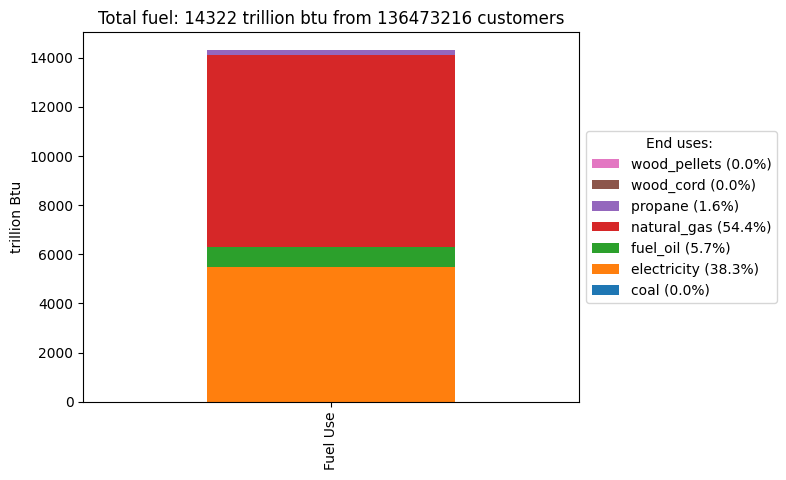

In [62]:
plot_normalized_stacked_fuel_uses(dfb, n_represented="auto") # "auto" or N_UNITS


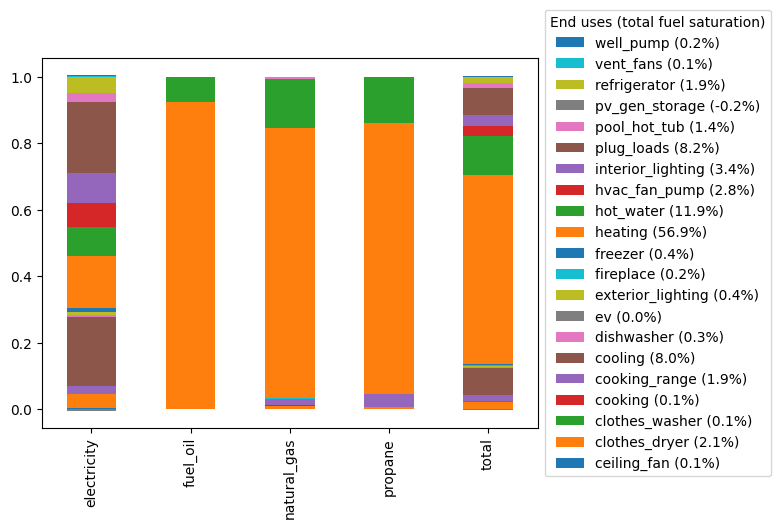

In [63]:
plot_normalized_stacked_end_uses_by_fuel(dfb)

-- Dwelling Unit Electricity [kWh] --
count     9931.000000
mean     11778.060417
std       7819.686343
min        423.487696
25%       6485.662779
50%       9816.708561
75%      15059.603467
max      79405.554919
Name: report_simulation_output.fuel_use_electricity_total_m_btu, dtype: float64


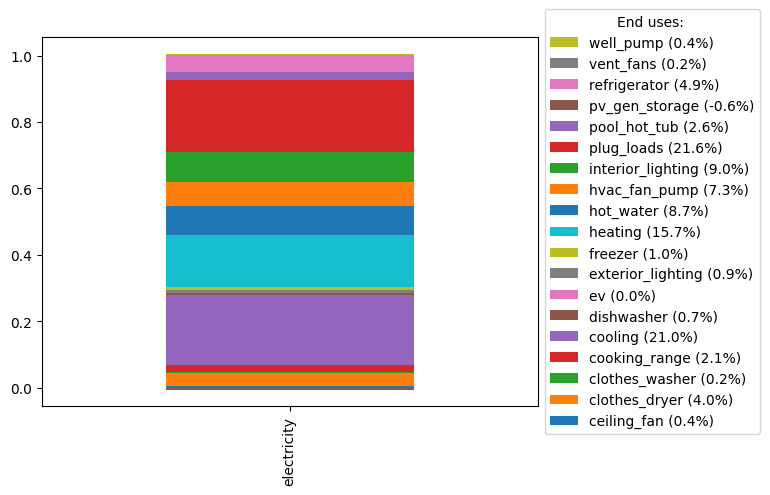

In [64]:
print("-- Dwelling Unit Electricity [kWh] --")
print((dfb["report_simulation_output.fuel_use_electricity_total_m_btu"]*MBTU_TO_KWH).describe())

plot_normalized_stacked_end_uses(dfb, fuel="electricity")

### G1. Peak delta

In [ ]:
metric = "report_simulation_output.peak_electricity_summer_total_w" # "report_simulation_output.peak_electricity_winter_total_w",
output_type = "delta"
dfs = get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)

hc = ["upgrade", "lmi"] # "lmi", "dac", "tenure"
nbins = 60

plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

In [ ]:
metric = "qoi_report.qoi_peak_magnitude_use_kw"
output_type = "delta"
dfs = get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)

hc = ["upgrade", "tenure"] # "lmi", "dac", "tenure"
nbins = 100

plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

In [ ]:
metric = "report_simulation_output.peak_electricity_summer_total_w"
output_type = "delta"
dfs = get_upgrade_saving_dataframe(dfb, DFU, metric, output_type=output_type)

hc = ["upgrade", "build_existing_model.geometry_building_type_recs"] # "lmi", "dac", "tenure"
nbins = 100

plot_histogram_saving(dfs, metric+f"_{output_type}", hc, bins=nbins, non_zero=False, title_prefix=None, xlim="best", dashline_bounds="p95")

### G1.b Unmet hours

In [ ]:
metric = 'report_simulation_output.unmet_hours_cooling_hr' # 'report_simulation_output.unmet_hours_cooling_hr', 'report_simulation_output.unmet_hours_heating_hr'
hc = "dac" # "lmi", "dac", "tenure"
nbins = 40

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

### G2. Savings

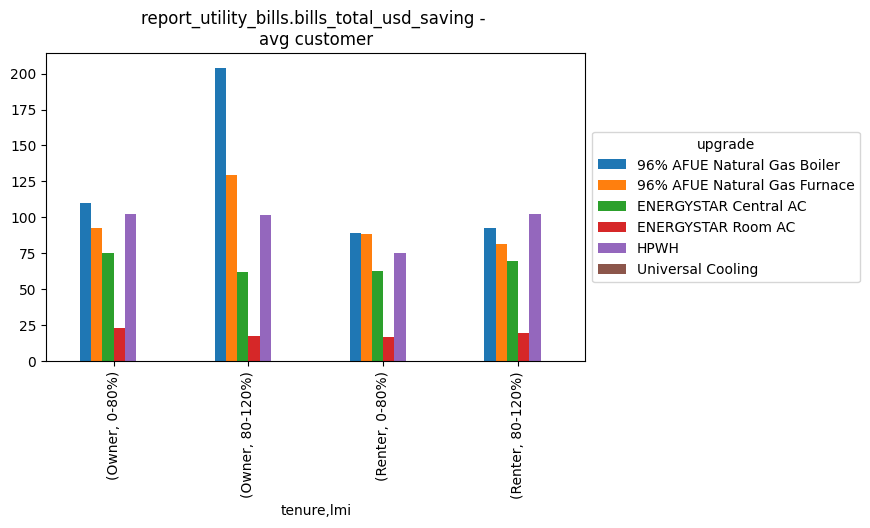

In [69]:
metric = "report_utility_bills.bills_total_usd" #"report_simulation_output.energy_use_total_m_btu"
dfs = get_upgrade_saving_dataframe(dfb, DFU, metric, output_type="saving")

groupby_cols = ["upgrade", "tenure", "lmi"] #NOTE: can add in: "dac",
plot_aggregated_metric(dfs, groupby_cols , metric+"_saving", operation="mean")

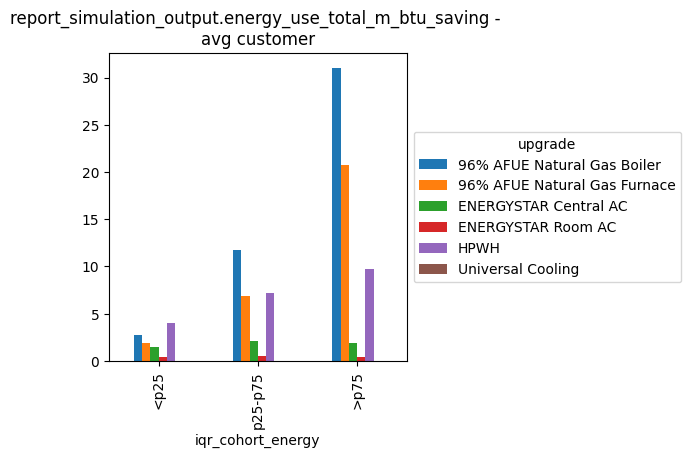

In [70]:
metric = "report_simulation_output.energy_use_total_m_btu" #"report_simulation_output.energy_use_total_m_btu" , "report_utility_bills.bills_total_usd"
dfs = get_upgrade_saving_dataframe(dfb, DFU, metric, output_type="saving")

groupby_cols = ["upgrade", "iqr_cohort_energy"] # iqr_cohort_electricity
plot_aggregated_metric(dfs, groupby_cols , metric+"_saving", operation="mean")

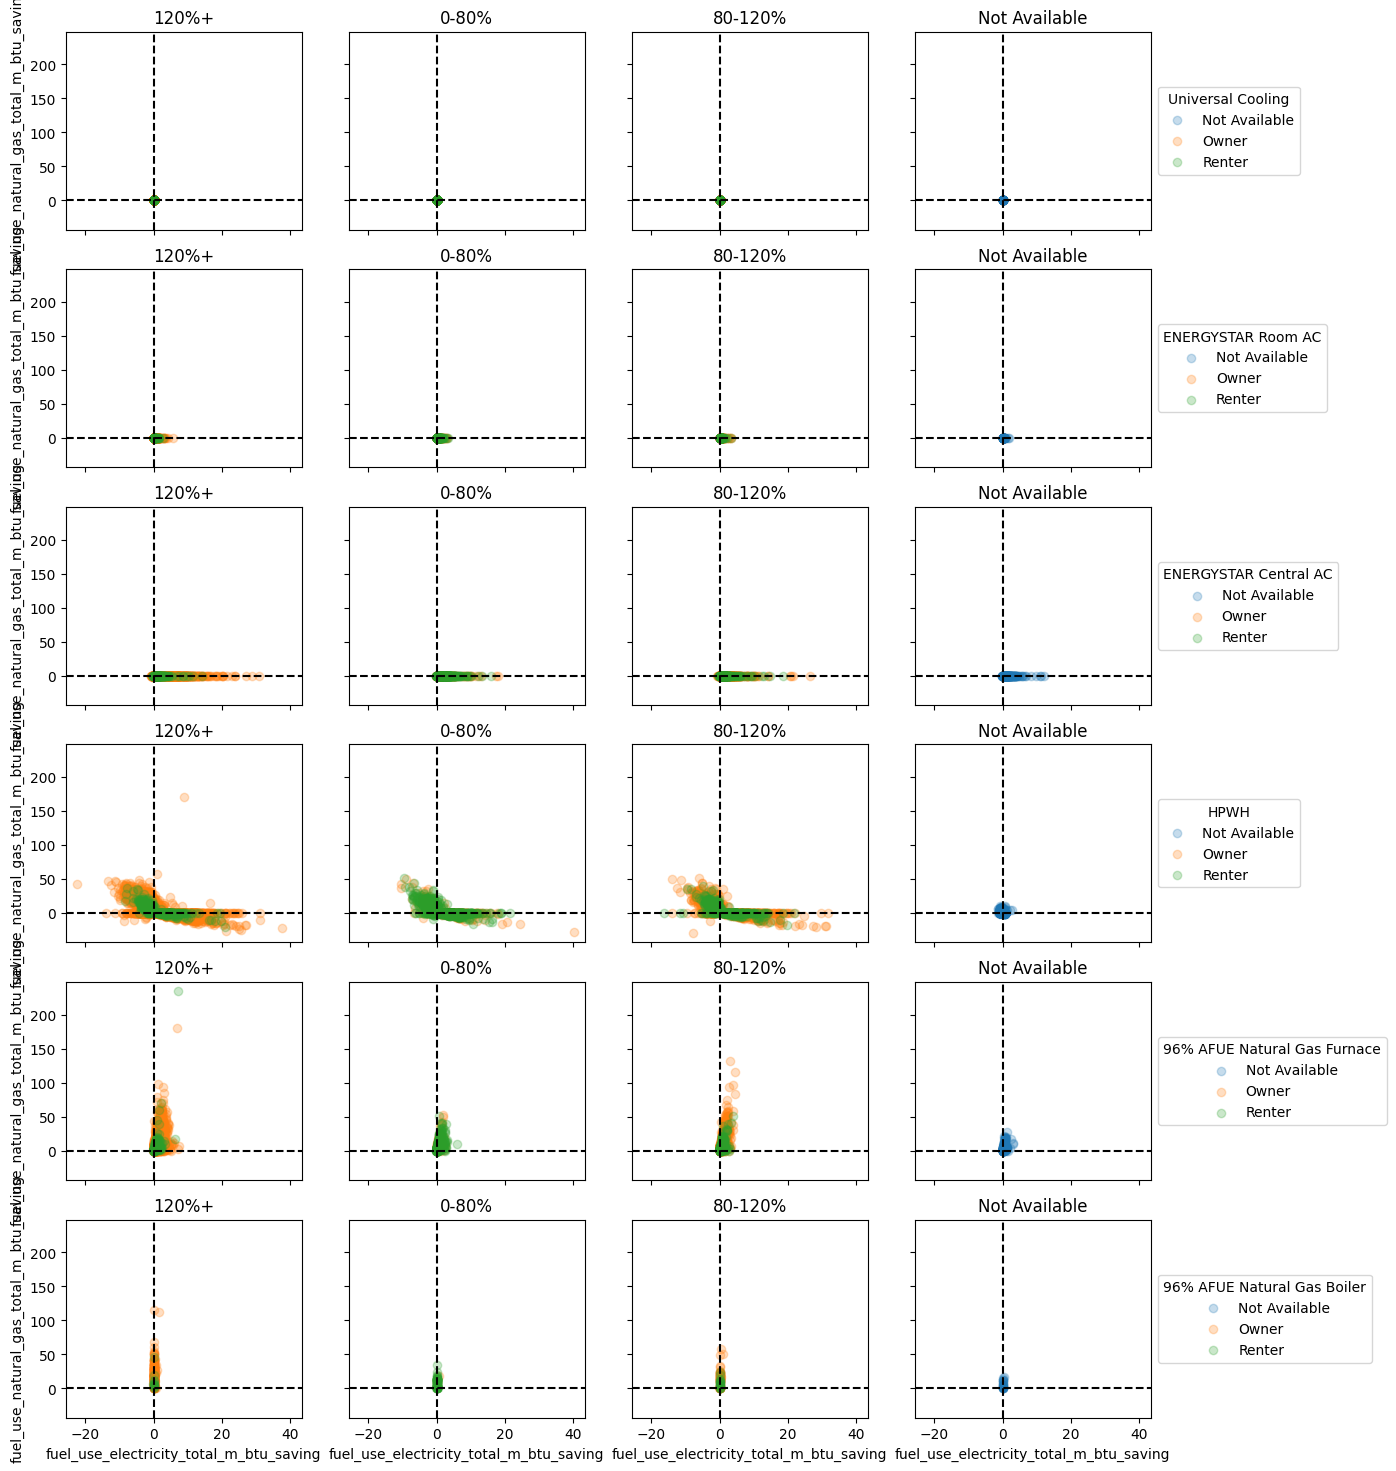

In [83]:
xmetric = "report_simulation_output.fuel_use_electricity_total_m_btu"
ymetric = "report_simulation_output.fuel_use_natural_gas_total_m_btu"
output_type = "saving"
dfs = pd.concat([
    get_upgrade_saving_dataframe(dfb, DFU, xmetric, output_type=output_type),
    get_upgrade_saving_dataframe(dfb, DFU, ymetric, output_type=output_type, add_metadata=False)[ymetric+f"_{output_type}"]
], axis=1)

xmetric = xmetric+f"_{output_type}"
ymetric = ymetric+f"_{output_type}"
plot_row_by = "upgrade"
plot_column_by = "lmi"
groupby_cols = ["tenure"]

plot_scatter(dfs, xmetric, ymetric, plot_row_by, plot_column_by, groupby_cols)

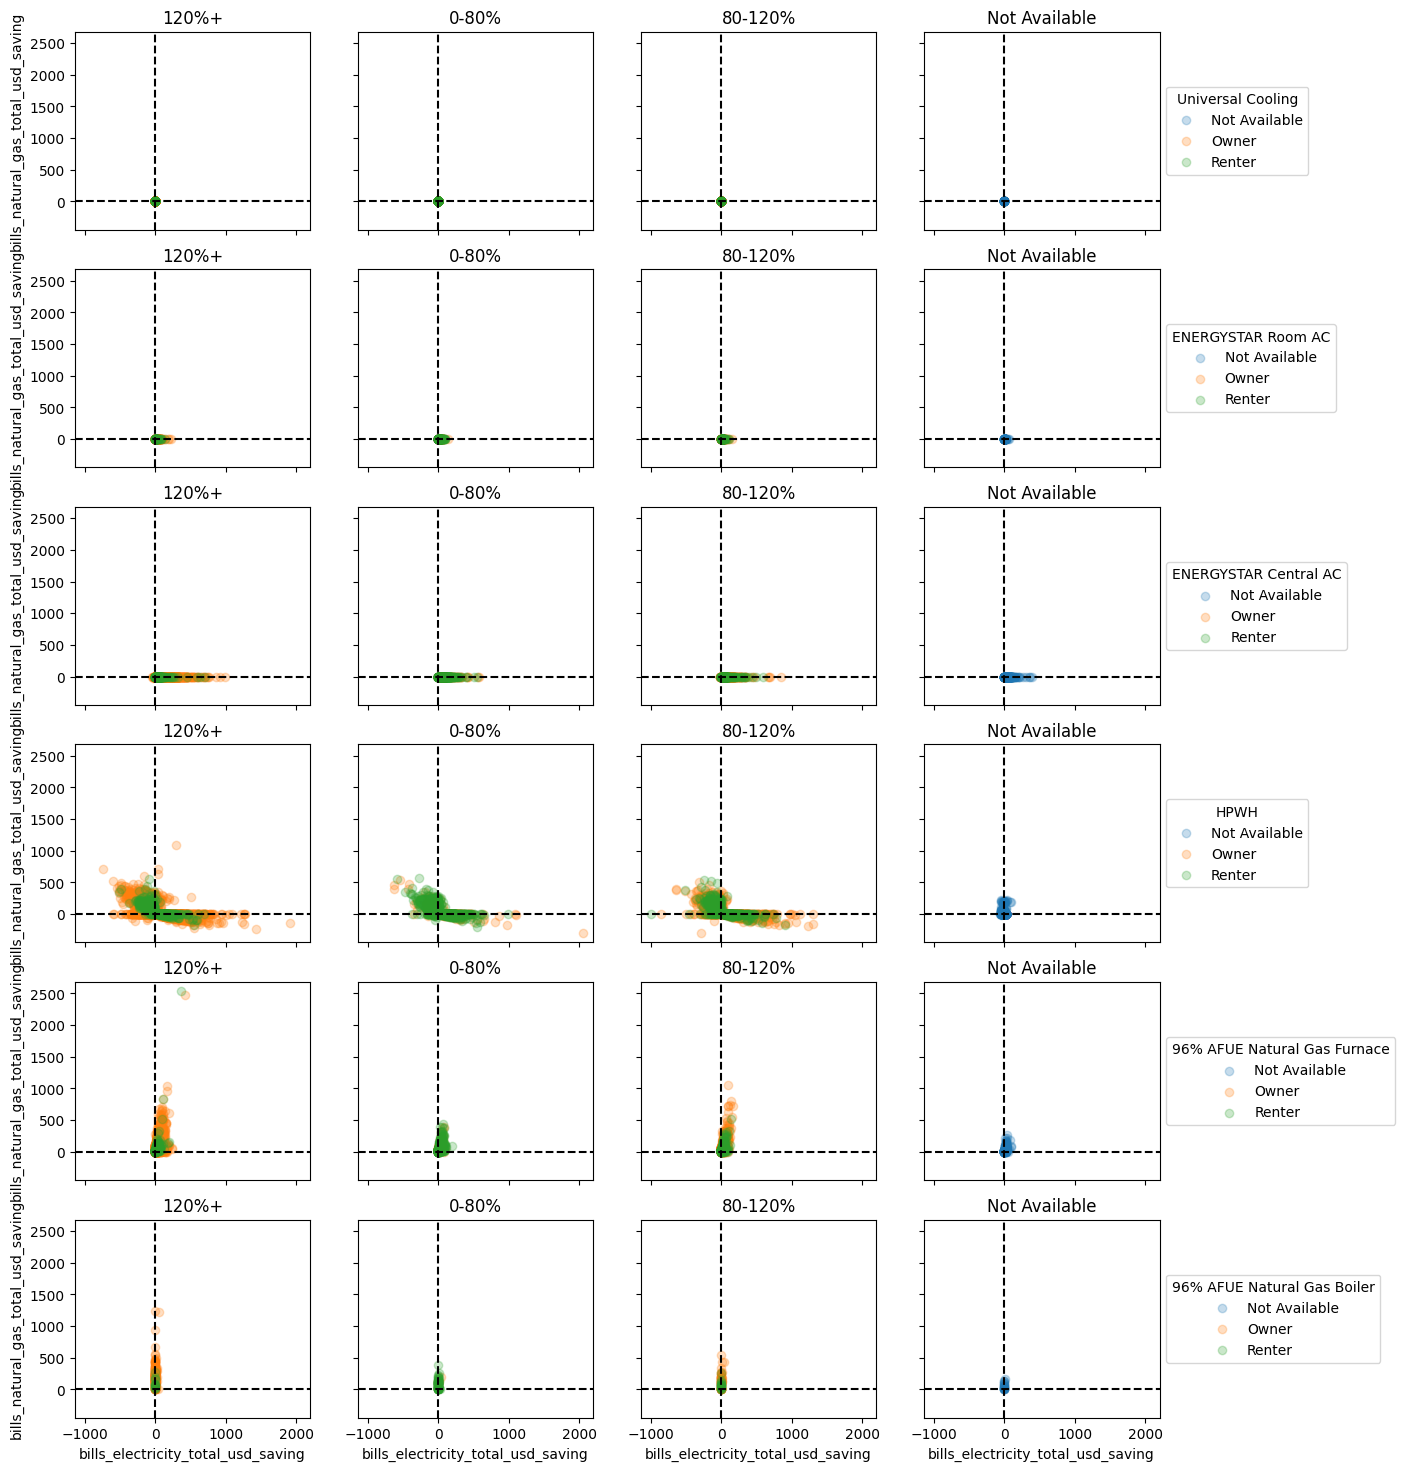

In [85]:
xmetric = "report_utility_bills.bills_electricity_total_usd"
ymetric = "report_utility_bills.bills_natural_gas_total_usd"
output_type = "saving"
dfs = pd.concat([
    get_upgrade_saving_dataframe(dfb, DFU, xmetric, output_type=output_type),
    get_upgrade_saving_dataframe(dfb, DFU, ymetric, output_type=output_type, add_metadata=False)[ymetric+f"_{output_type}"]
], axis=1)

xmetric = xmetric+f"_{output_type}"
ymetric = ymetric+f"_{output_type}"
plot_row_by = "upgrade"
plot_column_by = "lmi"
groupby_cols = ["tenure"]

plot_scatter(dfs, xmetric, ymetric, plot_row_by, plot_column_by, groupby_cols)

### G3. plot monthly heating & cooling

In [ ]:
metric = "cooling_electricity_kwh"
groupby_cols = ["upgrade", "build_existing_model.hvac_uses_cooling", "month"] # iqr_cohort_electricity

axes = df_heat_cool.groupby(groupby_cols)[metric].mean().unstack(level=0).plot(
    kind="bar", subplots=True, title=metric, sharey=True,
    figsize=(len(df_heat_cool[groupby_cols[1:]].drop_duplicates())*0.15+4, df_heat_cool[groupby_cols[0]].nunique()*1)
)
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, l, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(None)

In [ ]:
metric = "cooling_electricity_kwh"
groupby_cols = ["upgrade", "iqr_cohort_electricity"] # iqr_cohort_electricity

month = 4
print(f"month = {month}")
plot_aggregated_metric(df_heat_cool.loc[df_heat_cool["month"]==month], groupby_cols , metric, operation="mean", title_suffix=f"month={month}",  ylim=(0,160))

month = 3
print(f"month = {month}")
plot_aggregated_metric(df_heat_cool.loc[df_heat_cool["month"]==month], groupby_cols , metric, operation="mean", title_suffix=f"month={month}",  ylim=(0,160))

In [ ]:
metric = "report_simulation_output.load_cooling_delivered_m_btu" # "report_utility_bills.bills_total_usd" "electric_bill", "gas_bill"
hc = "lmi" # "lmi", "dac", "tenure"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

#### Heating

In [ ]:
metric =  "heating_all_fuel_kbtu"
groupby_cols = ["upgrade", "build_existing_model.heating_fuel"] # iqr_cohort_electricity

month = 8
print(f"month = {month}")
plot_aggregated_metric(df_heat_cool.loc[df_heat_cool["month"]==month], groupby_cols , metric, operation="mean", title_suffix=f"month={month}")

In [ ]:
metric =  "heating_all_fuel_kbtu"
groupby_cols = ["upgrade", "build_existing_model.heating_fuel"] # iqr_cohort_electricity

month = 12
print(f"month = {month}")
plot_aggregated_metric(df_heat_cool.loc[df_heat_cool["month"]==month], groupby_cols , metric, operation="mean", title_suffix=f"month={month}")

In [ ]:
metric =  "heating_all_fuel_kbtu"
groupby_cols = ["upgrade", "build_existing_model.heating_fuel"] # iqr_cohort_electricity

month = 4
print(f"month = {month}")
plot_aggregated_metric(df_heat_cool.loc[df_heat_cool["month"]==month], groupby_cols , metric, operation="count", title_suffix=f"month={month}")

In [ ]:
df_heat_cool.loc[df_heat_cool["month"]==12].groupby(groupby_cols)[metric].mean()

In [ ]:
metric = "heating_all_fuel_kbtu"
groupby_cols = ["upgrade", "build_existing_model.heating_fuel", "month"] # iqr_cohort_electricity

axes = df_heat_cool.groupby(groupby_cols)[metric].mean().unstack(level=0).plot(
    kind="bar", subplots=True, title=metric,
    figsize=(len(df_heat_cool[groupby_cols[1:]].drop_duplicates())*0.15+4, df_heat_cool[groupby_cols[0]].nunique()*1)
)
for ax in axes:
    h, l = ax.get_legend_handles_labels()
    ax.legend(h, l, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(None)

### G4. Histograms of bills and energy

In [86]:
metric = "energy_burden_pct" # "report_utility_bills.bills_total_usd" "electric_bill", "gas_bill"
hc = "lmi" # "lmi", "tenure"
nbins = 20

# >10% severely burdened, 10-6% moderately burdened

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

TypeError: '<' not supported between instances of 'str' and 'int'

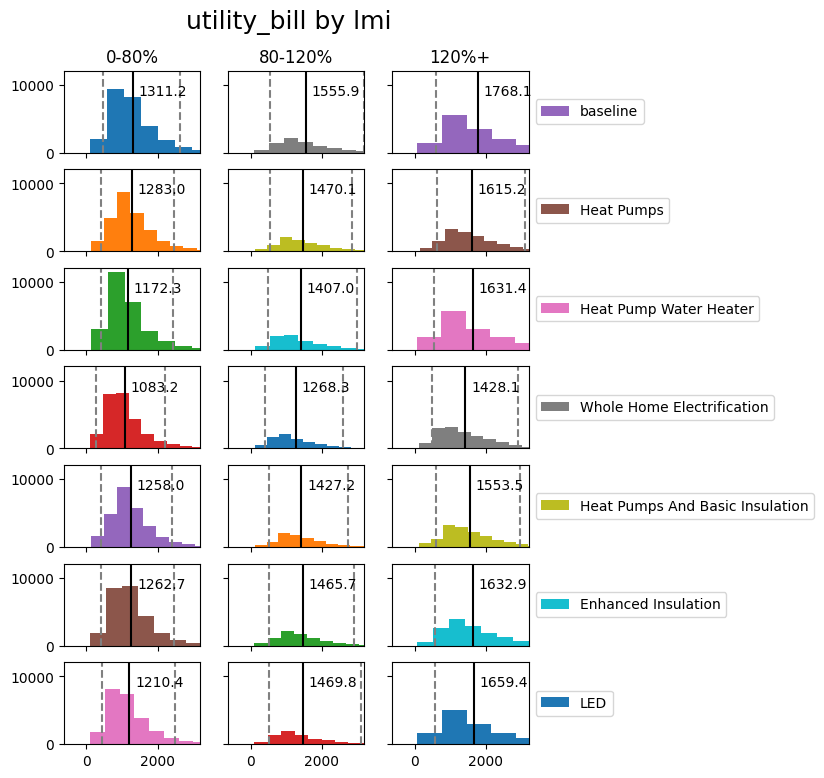

In [84]:
metric = "report_utility_bills.bills_total_usd" # "report_utility_bills.bills_total_usd" "electric_bill", "gas_bill"
hc = "lmi" # "lmi", "dac", "tenure"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

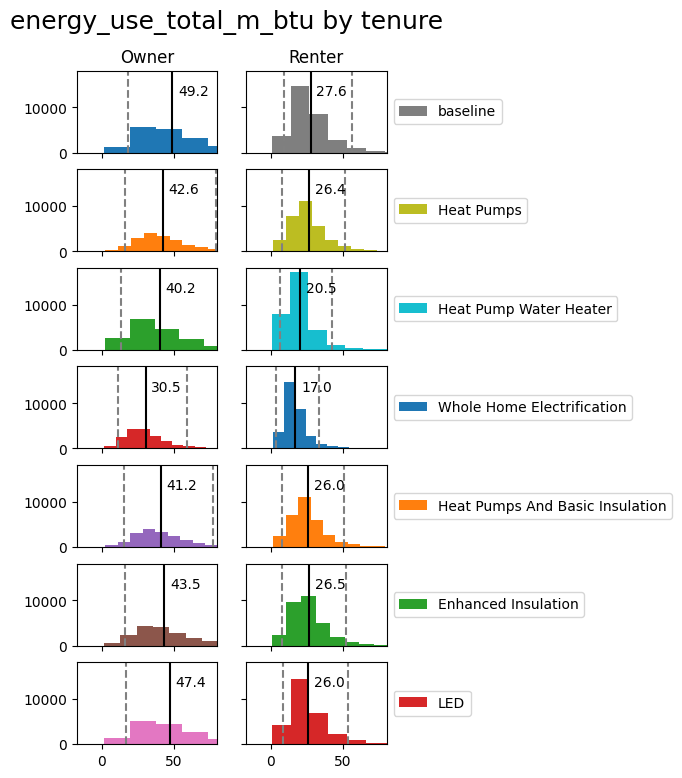

In [85]:
metric = "report_simulation_output.energy_use_total_m_btu" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "tenure" # "lmi", "dac", "tenure"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

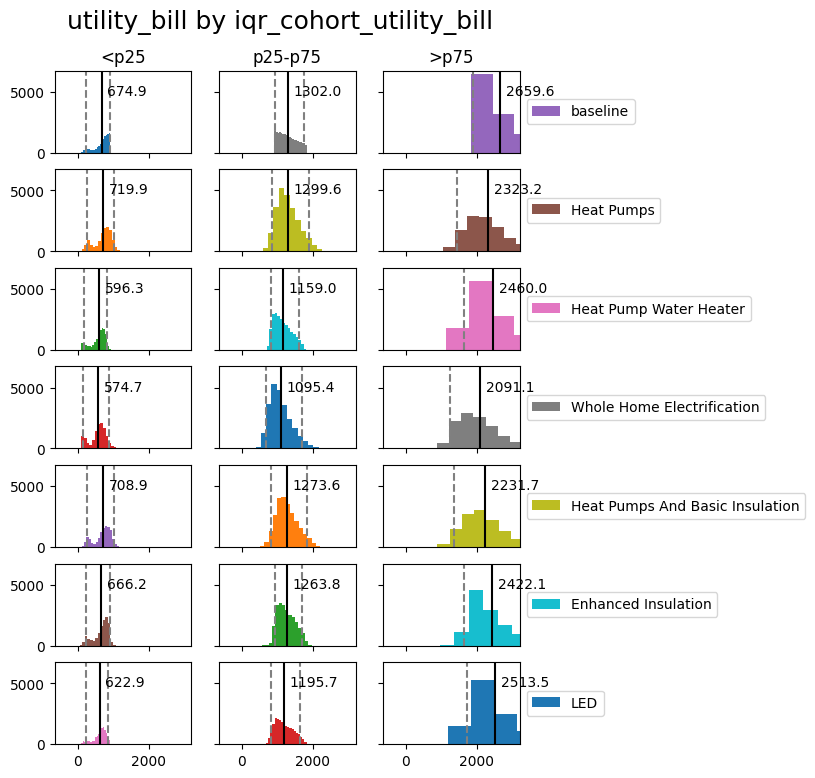

In [86]:
metric = "report_utility_bills.bills_total_usd" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "iqr_cohort_utility_bill" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

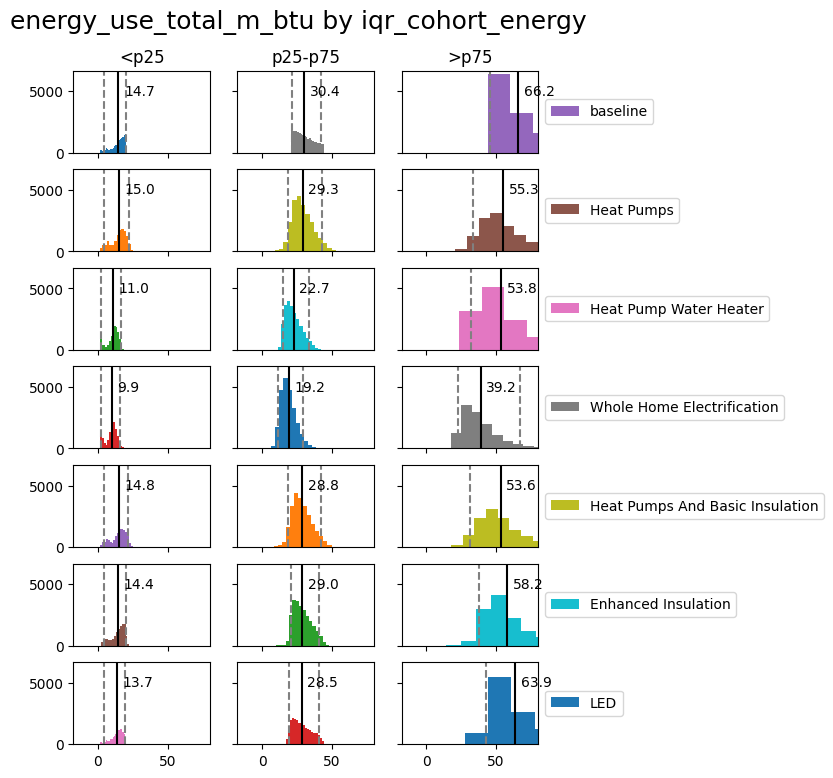

In [87]:
metric = "report_simulation_output.energy_use_total_m_btu" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "iqr_cohort_energy" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

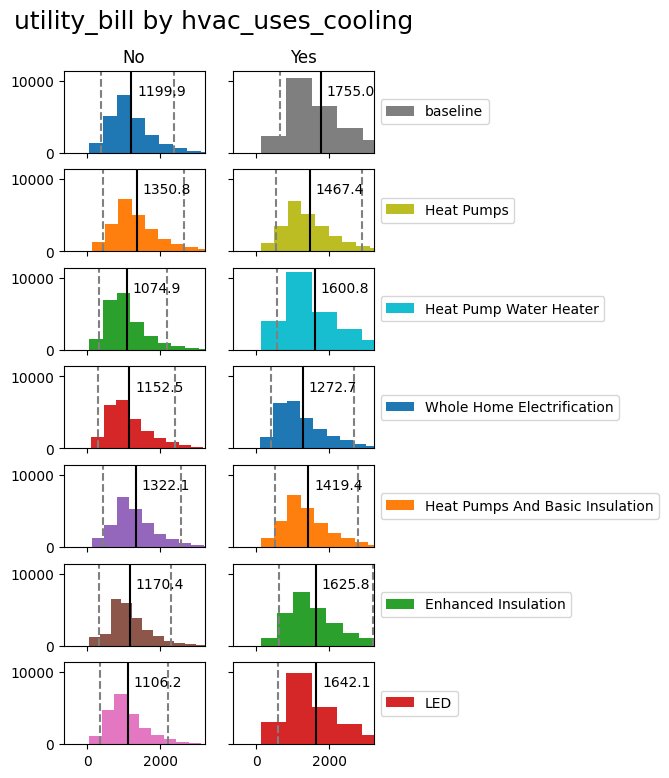

In [88]:
metric = "report_utility_bills.bills_total_usd" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "build_existing_model.hvac_uses_cooling" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

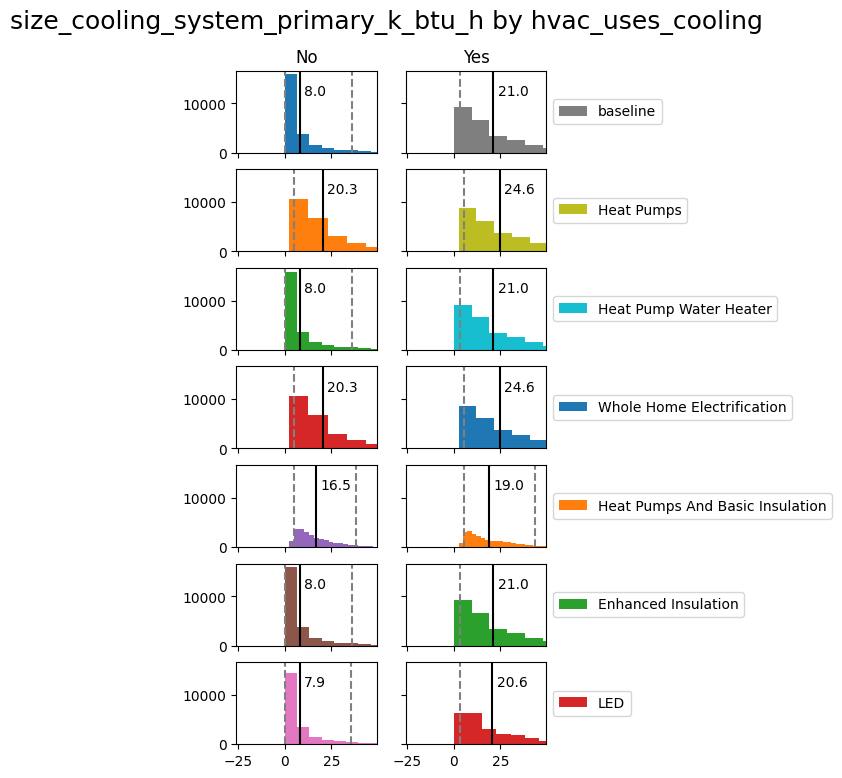

In [89]:
metric = "upgrade_costs.size_cooling_system_primary_k_btu_h" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "build_existing_model.hvac_uses_cooling" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 50

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

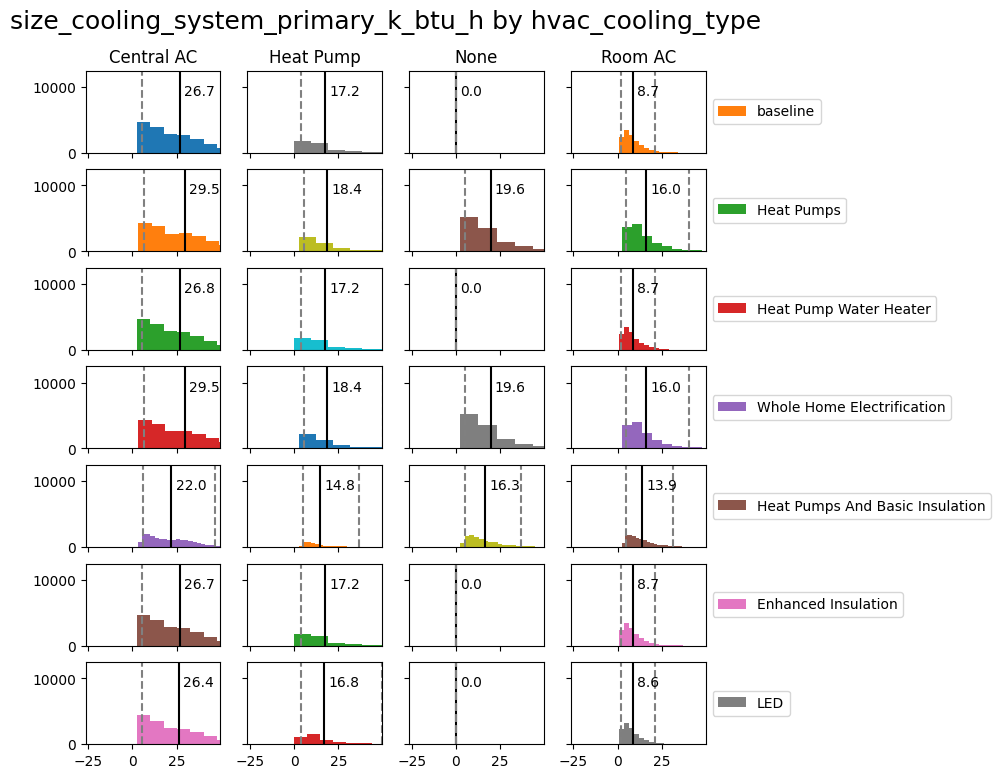

In [90]:
metric = "upgrade_costs.size_cooling_system_primary_k_btu_h"
hc = "build_existing_model.hvac_cooling_type" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 50

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

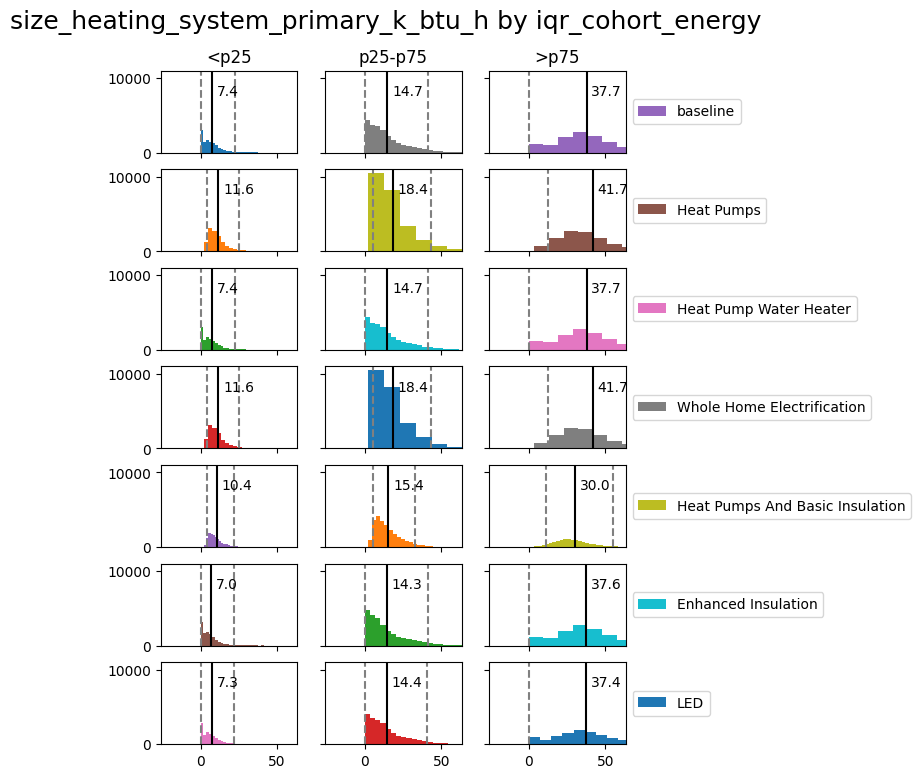

In [91]:
metric = "upgrade_costs.size_heating_system_primary_k_btu_h"
hc = "iqr_cohort_energy" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 50

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

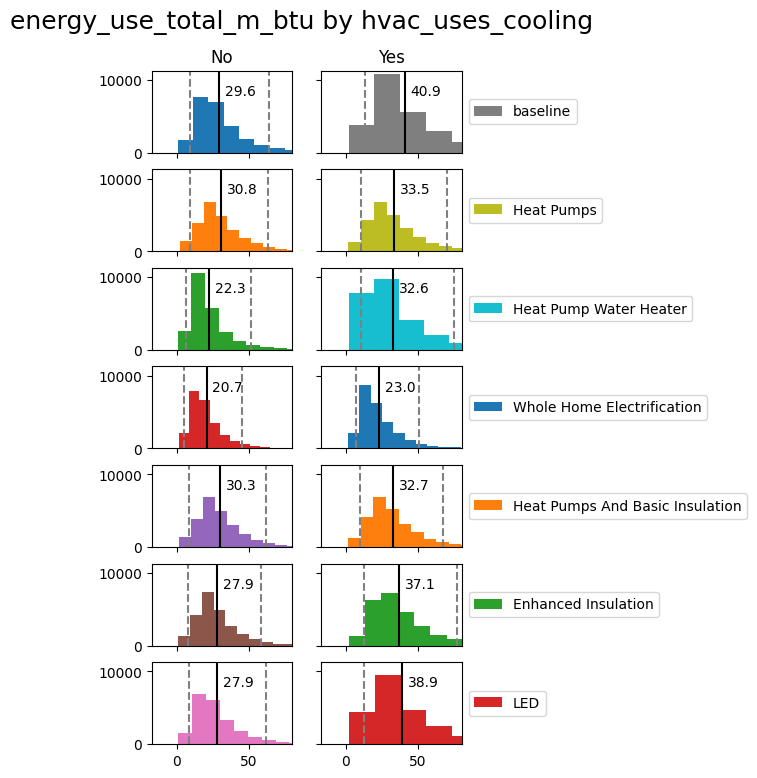

In [92]:
metric = "report_simulation_output.energy_use_total_m_btu" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "build_existing_model.hvac_uses_cooling" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")

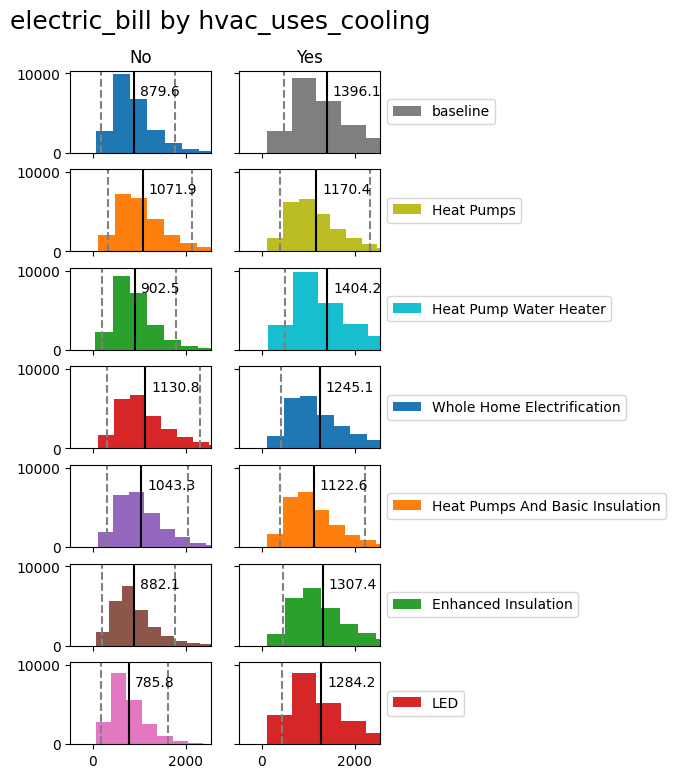

In [93]:
metric = "electric_bill" # "report_simulation_output.energy_use_total_m_btu", 'report_simulation_output.fuel_use_electricity_total_m_btu'
hc = "build_existing_model.hvac_uses_cooling" # "iqr_cohort_electricity", "iqr_cohort_utility_bill", "iqr_cohort_electric_bill"
nbins = 20

plot_histogram_total(dfb, DFU, metric, hc, nbins, xmax="best", dashline_bounds="p95")